In [ ]:
# STEP 1: Normalize CSVs from RTHK, SCMP, HKFP
import pandas as pd
from pathlib import Path

# Load all sources
def load_and_normalize(file_path, source):
    df = pd.read_csv(file_path)

    if source == 'RTHK':
        return df.rename(columns={
            'full_content': 'content',
            'pub_date_formatted': 'pub_date',
            'category': 'category',
            'title': 'title'
        })[['title', 'content', 'pub_date', 'category']].assign(source='RTHK')

    elif source == 'HKFP':
        return df.rename(columns={
            'full_content': 'content',
            'pub_date_formatted': 'pub_date',
            'category': 'category',
            'title': 'title'
        })[['title', 'content', 'pub_date', 'category']].assign(source='HKFP')

    elif source == 'SCMP':
        return df.rename(columns={
            'full_paragraphs': 'content',
            'pub_date_formatted': 'pub_date',
            # 'subcategory': 'category',
            'title': 'title'
        })[['title', 'content', 'pub_date', 'category']].assign(source='SCMP')

# define custom path if necessary
base_path = Path("hk_news_old")
rthk = load_and_normalize(base_path / "rthk_news.csv", "RTHK")
hkfp = load_and_normalize(base_path / "hkfp_news.csv", "HKFP")
scmp = load_and_normalize(base_path / "scmp_news.csv", "SCMP")

all_news = pd.concat([rthk, hkfp, scmp], ignore_index=True)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/user/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


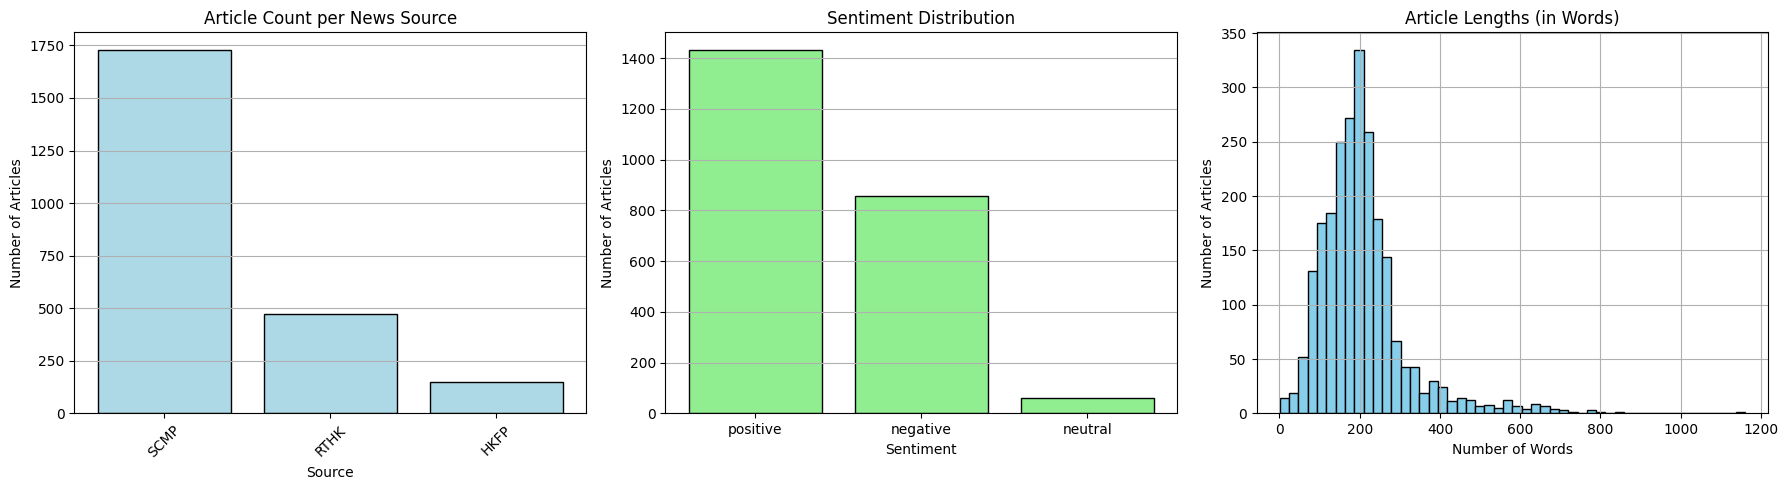

In [48]:
import matplotlib.pyplot as plt
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import download
from collections import Counter
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Download VADER once if not already
download("vader_lexicon")
sia = SentimentIntensityAnalyzer()

# Prepare data
all_news["content_length"] = all_news["content"].apply(lambda x: len(str(x).split()))
all_news["sentiment_score"] = all_news["content"].apply(lambda x: sia.polarity_scores(str(x))["compound"])
all_news["sentiment_label"] = all_news["sentiment_score"].apply(
    lambda s: "positive" if s >= 0.05 else "negative" if s <= -0.05 else "neutral"
)
source_counts = all_news["source"].value_counts()
sentiment_counts = all_news["sentiment_label"].value_counts()
lengths = all_news["content_length"]

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Article count per source
axes[0].bar(source_counts.index, source_counts.values, color="lightblue", edgecolor="black")
axes[0].set_title("Article Count per News Source")
axes[0].set_xlabel("Source")
axes[0].set_ylabel("Number of Articles")
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, axis='y')

# Sentiment distribution
axes[1].bar(sentiment_counts.index, sentiment_counts.values, color="lightgreen", edgecolor="black")
axes[1].set_title("Sentiment Distribution")
axes[1].set_xlabel("Sentiment")
axes[1].set_ylabel("Number of Articles")
axes[1].grid(True, axis='y')

# Article length distribution
axes[2].hist(lengths, bins=50, color="skyblue", edgecolor="black")
axes[2].set_title("Article Lengths (in Words)")
axes[2].set_xlabel("Number of Words")
axes[2].set_ylabel("Number of Articles")
axes[2].grid(True)

plt.tight_layout()
plt.show()

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


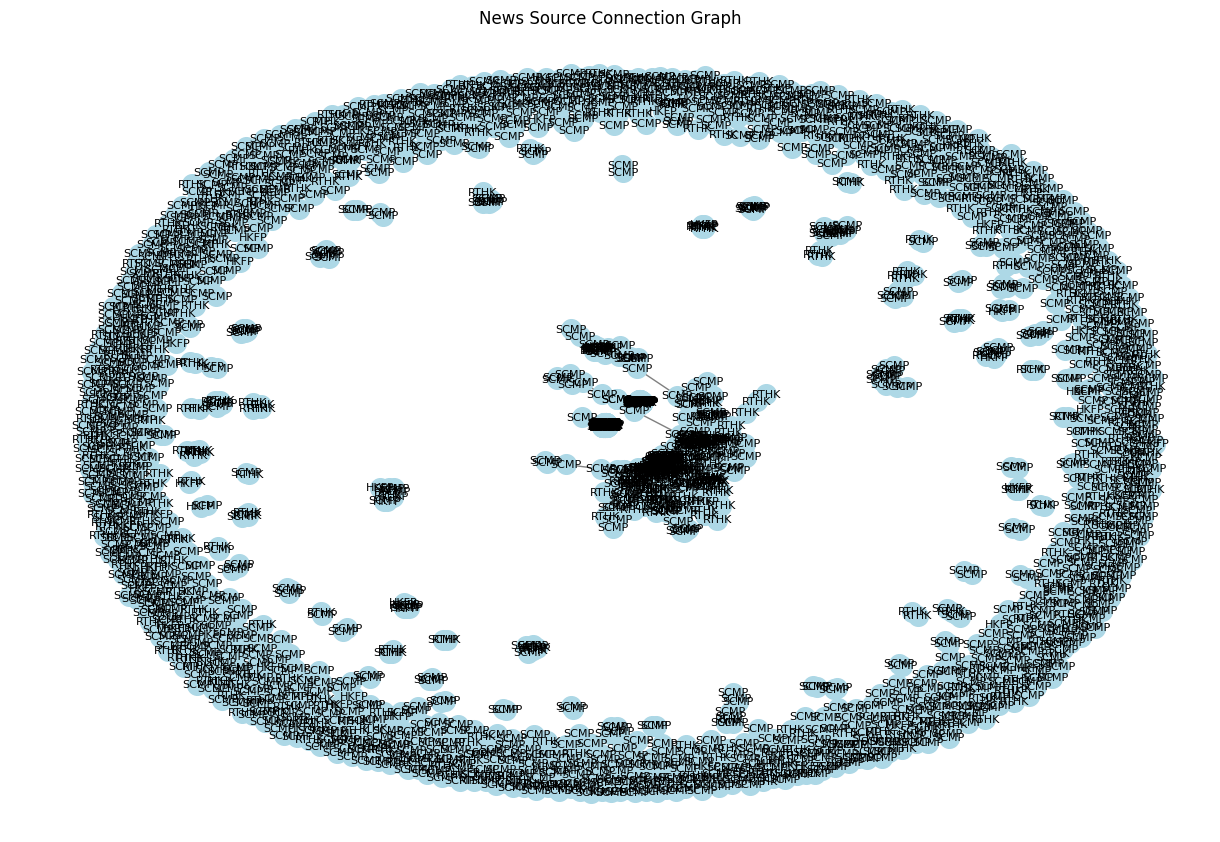

                                               title  \
0  Shenzhou-20 blasts off for Tiangong space station   
1       Govt working to improve labour import scheme   
2   HK stocks slip after Beijing's takedown of Trump   
3  Food for thought as konjac jelly ban move hardens   
4       HK$30 movie tickets for Cinema Day on May 10   

                                             summary  cluster  
0  China has launched its third crewed mission to...        4  
1  The Hong Kong government is considering ways t...        4  
2                        All images are copyrighted.        1  
3  Officials in Hong Kong are considering a ban o...        4  
4  The organisers of Hong Kong's annual Cinema Da...        4  


In [ ]:
from transformers import PegasusTokenizer, PegasusForConditionalGeneration
from sentence_transformers import SentenceTransformer, util
import torch

# Load models
summarizer_name = "google/pegasus-xsum"
tokenizer = PegasusTokenizer.from_pretrained(summarizer_name)
model = PegasusForConditionalGeneration.from_pretrained(summarizer_name)
embedder = SentenceTransformer("all-MiniLM-L6-v2")

# Summarize and embed
def summarize(text):
    inputs = tokenizer(text, truncation=True, padding="longest", return_tensors="pt")
    summary_ids = model.generate(**inputs)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

all_news["summary"] = all_news["content"].apply(summarize)
all_news["embedding"] = all_news["summary"].apply(lambda x: embedder.encode(x, convert_to_tensor=True))

# STEP 3: Cluster viewpoints
from sklearn.cluster import KMeans
import numpy as np

X = torch.stack(all_news["embedding"].tolist()).cpu().numpy()
kmeans = KMeans(n_clusters=5, random_state=42).fit(X)
all_news["cluster"] = kmeans.labels_

# STEP 4: Similarity graph (Source Connection)
import networkx as nx
import matplotlib.pyplot as plt

similarities = util.pytorch_cos_sim(torch.tensor(X), torch.tensor(X))
G = nx.Graph()
for i, row in all_news.iterrows():
    G.add_node(i, label=row["title"][:50] + ("..." if len(row["title"]) > 50 else ""), source=row["source"])
    for j in range(i+1, len(all_news)):
        sim = similarities[i][j].item()
        if sim > 0.65:
            G.add_edge(i, j, weight=round(sim, 2))

# Visualization
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=False, node_color='lightblue', node_size=200, edge_color='gray')
nx.draw_networkx_labels(G, pos, labels={i: all_news.loc[i, "source"] for i in G.nodes}, font_size=8)
plt.title("News Source Connection Graph")
plt.show()

# Show samples
print(all_news[["title", "summary", "cluster"]].head())


In [15]:
all_news.head()

,title,content,pub_date,pub_date,category,source,summary,embedding,cluster
0,Shenzhou-20 blasts off for Tiangong space station,The Shenzhou-20 spacecraft -- atop a Long Marc...,"Thu, 24 Apr 2025 19:36:00 +0800",2025-04-24 19:36:00,greater_china,RTHK,China has launched its third crewed mission to...,"[tensor(-0.0099, device='cuda:0'), tensor(-0.0...",4
1,Govt working to improve labour import scheme,Acting Chief Secretary Warner Cheuk said on Th...,"Thu, 24 Apr 2025 18:19:07 +0800",2025-04-24 18:19:07,local,RTHK,The Hong Kong government is considering ways t...,"[tensor(-0.0480, device='cuda:0'), tensor(-0.0...",4
2,HK stocks slip after Beijing's takedown of Trump,Asian markets were mixed on Thursday as China ...,"Thu, 24 Apr 2025 17:59:43 +0800",2025-04-24 17:59:43,finance,RTHK,All images are copyrighted.,"[tensor(0.0065, device='cuda:0'), tensor(0.012...",1
3,Food for thought as konjac jelly ban move hardens,The government said on Thursday it will listen...,"Thu, 24 Apr 2025 17:23:12 +0800",2025-04-24 17:23:12,local,RTHK,Officials in Hong Kong are considering a ban o...,"[tensor(-0.0111, device='cuda:0'), tensor(0.03...",4
4,HK$30 movie tickets for Cinema Day on May 10,"More than 200,000 people are expected to head ...","Thu, 24 Apr 2025 17:13:06 +0800",2025-04-24 17:13:06,local,RTHK,The organisers of Hong Kong's annual Cinema Da...,"[tensor(0.0223, device='cuda:0'), tensor(-0.01...",4


In [9]:
# save model
import os
import joblib
import torch

os.makedirs("news_pipeline_model", exist_ok=True)

joblib.dump(kmeans, "news_pipeline_model/kmeans_model.pkl")

all_news_no_embed = all_news.copy()
all_news_no_embed["embedding"] = all_news_no_embed["embedding"].apply(lambda x: x.tolist())
all_news_no_embed.to_csv("news_pipeline_model/all_news_with_clusters.csv", index=False)

torch.save(torch.stack(all_news["embedding"].tolist()), "news_pipeline_model/news_embeddings.pt")

In [12]:
all_news.head(1)

,title,content,pub_date,pub_date,category,source,summary,embedding,cluster
0,Shenzhou-20 blasts off for Tiangong space station,The Shenzhou-20 spacecraft -- atop a Long Marc...,"Thu, 24 Apr 2025 19:36:00 +0800",2025-04-24 19:36:00,greater_china,RTHK,China has launched its third crewed mission to...,"[tensor(-0.0099, device='cuda:0'), tensor(-0.0...",4


In [10]:
# Show the article title, summary, and cluster label
i = 0
print("Title:", all_news.loc[i, "title"])
print("Summary:", all_news.loc[i, "summary"])
print("Cluster label:", all_news.loc[i, "cluster"])

Title: Shenzhou-20 blasts off for Tiangong space station
Summary: China has launched its third crewed mission to the Tiangong space station.
Cluster label: 4


k=5: Silhouette Score = 0.1127
k=10: Silhouette Score = 0.1192
k=15: Silhouette Score = 0.1206
k=20: Silhouette Score = 0.1236
k=25: Silhouette Score = 0.1218
k=30: Silhouette Score = 0.1241
k=35: Silhouette Score = 0.1233
k=40: Silhouette Score = 0.1226
k=45: Silhouette Score = 0.1226
k=50: Silhouette Score = 0.1255
k=55: Silhouette Score = 0.1245
k=60: Silhouette Score = 0.1263
k=65: Silhouette Score = 0.1252
k=70: Silhouette Score = 0.1274
k=75: Silhouette Score = 0.1289
k=80: Silhouette Score = 0.1303
k=85: Silhouette Score = 0.1296
k=90: Silhouette Score = 0.1292
k=95: Silhouette Score = 0.1272
k=100: Silhouette Score = 0.1270
k=105: Silhouette Score = 0.1273
k=110: Silhouette Score = 0.1271
k=115: Silhouette Score = 0.1269
k=120: Silhouette Score = 0.1281
k=125: Silhouette Score = 0.1268
k=130: Silhouette Score = 0.1283
k=135: Silhouette Score = 0.1287
k=140: Silhouette Score = 0.1282
k=145: Silhouette Score = 0.1304
k=150: Silhouette Score = 0.1352
k=155: Silhouette Score = 0.13

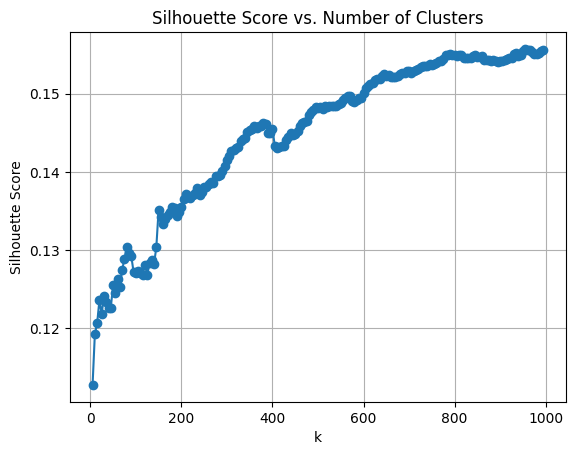

In [22]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

scores = []
k_range = range(5, 1000, 5)  # Try k = 5, 10, 15, ..., 30

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X)
    score = silhouette_score(X, labels)
    scores.append(score)
    print(f"k={k}: Silhouette Score = {score:.4f}")

# Plot results
plt.plot(k_range, scores, marker='o')
plt.title("Silhouette Score vs. Number of Clusters")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

In [23]:
kmeans = KMeans(n_clusters=1000, random_state=42).fit(X)
all_news["cluster"] = kmeans.labels_

In [24]:
for c in sorted(all_news["cluster"].unique()):
    print(f"\n=== 🧠 Cluster {c} ===")
    cluster_df = all_news[all_news["cluster"] == c]
    
    # Show number of articles in this cluster
    print(f"Total articles: {len(cluster_df)}\n")
    
    # Show top 3 examples
    for i, row in cluster_df.head(3).iterrows():
        print(f"📌 Title: {row['title']}")
        print(f"📝 Summary: {row['summary'][:200]}...\n")


=== 🧠 Cluster 0 ===
Total articles: 2

📌 Title: Ex-Tesla Optimus engineer leaves to launch robotics start-up in Palo Alto, Shenzhen
📝 Summary: The winner of this year’s BBC Young Scientist of the Year award has been revealed....

📌 Title: Hong Kong Sports Stars: golden Olympic duo Vivian Kong, Cheung Ka-long win top awards
📝 Summary: The BBC Sports Personality of the Year and Sportswoman of the Year awards were held in London on Sunday....


=== 🧠 Cluster 1 ===
Total articles: 1

📌 Title: HK to keep zero tariffs amid trade war: customs chief
📝 Summary: Hong Kong will stick to its zero-tariffs regime on imports, its top customs official has said....


=== 🧠 Cluster 2 ===
Total articles: 165

📌 Title: HK stocks slip after Beijing's takedown of Trump
📝 Summary: All images are copyrighted....

📌 Title: Beijing rejects US trade talks claims as 'fake news'
📝 Summary: All images are copyrighted....

📌 Title: South Korea halts probe into adoptions fraud
📝 Summary: All images are copyrighted..